# ＜Numpyによる演習＞：ロジスティック回帰

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成
　　正規分布に従う乱数に基づいて中心をずらしてそれぞれ点群を発生させ、中心位置に合わせて2クラス｛0，1｝に分類する

In [2]:
n_sample = 100
harf_n_sample = 50
var = .2

def gen_data(n_sample, harf_n_sample):
    x0 = np.random.normal(size=n_sample).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=n_sample).reshape(-1, 2) + 1.
    x_train = np.concatenate([x0, x1])
    y_train = np.concatenate([np.zeros(harf_n_sample), np.ones(harf_n_sample)]).astype(np.int)
    return x_train, y_train

def plt_data(x_train, y_train):
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.legend()

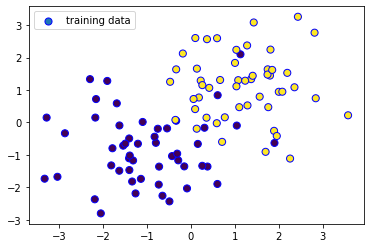

In [3]:
#データ作成
x_train, y_train = gen_data(n_sample, harf_n_sample)
#データ表示
plt_data(x_train, y_train)

## ロジスティック回帰モデル

識別モデルとして$p(y=1 | \boldsymbol{x}; \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$を用いる。

ただし、$\sigma(\cdot)$はシグモイド関数であり、$\sigma(h) = \frac{1}{1 + \exp{(-h)}}$で定義される。

また、陽には書かないが、$\boldsymbol{x}$には定数項のための$1$という要素があることを仮定する。

## 学習

訓練データ$X = [\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ..., \boldsymbol{x}_{n}]^{\mathrm{T}}, \boldsymbol{y} = [y_{1}, y_{2}, ..., y_{n}]^{\mathrm{T}} (y_{i} = \{0, 1\})$に対して尤度関数$L$は以下のように書ける。

$L(\boldsymbol{w}) = \prod_{i=1}^{n} p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})^{y_{i}} (1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))^{1 - y_{i}}$

負の対数尤度関数は

$- \log{L(\boldsymbol{w})} = - \sum_{i=1}^{n} \left[ y_{i} \log{p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})} + (1 - y_{i}) \log{(1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))} \right]$

のように書ける。 これを最小化する$\boldsymbol{w}$を求める。

$\frac{d \sigma(h)}{d h} = \sigma(h)(1 - \sigma(h))$と書けることを考慮し、負の対数尤度関数を$\boldsymbol{w}$で偏微分すると、

\begin{eqnarray}
\frac{\partial }{\partial \boldsymbol{w}} (-\log{L(\boldsymbol{w})}) &=& -\sum_{i=1}^{n} \left[ y_{i} (1 - \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i})) - (1 - y_{i}) \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) \right] \boldsymbol{x}_{i}  \\
&=& \sum_{i=1}^{n} \left( \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) - y_{i} ) \right) \boldsymbol{x}_{i}
\end{eqnarray}

この式が$0$となる$\boldsymbol{w}$は解析的に求められないので、今回は$-\log{L(\boldsymbol{w})}$の最小化問題を最急降下法を用いて解く。

最急降下法では学習率を$\eta$とすると、以下の式で$\boldsymbol{w}$を更新する。

$\boldsymbol{w} \leftarrow \boldsymbol{w} - \eta \frac{\partial }{\partial \boldsymbol{w}} (-\log{L(\boldsymbol{w})})$

In [4]:
# バイアスw0に対する入力項1を1軸方向に前側に付け加える
def add_one(x):
    return np.concatenate([np.ones(len(x))[:, None], x], axis=1)

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sgd(X_train, max_iter, eta):
    w = np.zeros(X_train.shape[1])
    for _ in range(max_iter):
        w_prev = np.copy(w)
        sigma = sigmoid(np.dot(X_train, w))
        grad = np.dot(X_train.T, (sigma - y_train))     # 微分の計算
        w -= eta * grad
        if np.allclose(w, w_prev):
            return w
    return w

X_train = add_one(x_train)
max_iter=100
eta = 0.01
w = sgd(X_train, max_iter, eta)

## 予測

入力に対して、$y=1$である確率を出力する。よって

$p(y=1 | \boldsymbol{x}; \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$の値が

$0.5$より大きければ1に、小さければ0に分類する。

In [6]:
xx0, xx1 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xx = np.array([xx0, xx1]).reshape(2, -1).T

In [7]:
# 識別等高線を描くために、メッシュの各点が｛0,1｝のどちらのクラスに分類されるかを判定
X_test = add_one(xx)
proba = sigmoid(np.dot(X_test, w))
y_pred = (proba > 0.5).astype(np.int)

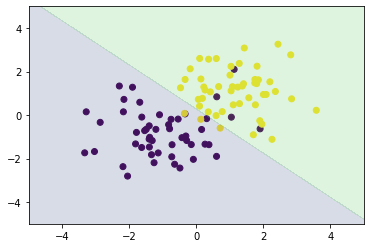

In [8]:
# 入力データの各点をクラス別に色分けしてプロットすると共に、クラスの識別等高線をプロット
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))

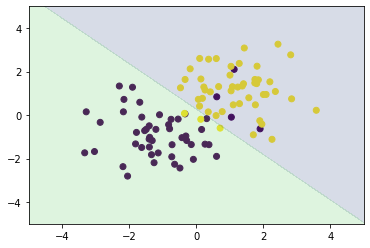

In [9]:
#sklearn実装

from sklearn.linear_model import LogisticRegression
model=LogisticRegression(fit_intercept=True)
model.fit(x_train, y_train)
proba = model.predict_proba(xx)
y_pred = (proba > 0.5).astype(np.int)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba[:, 0].reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))

# ＜Scikit-learnによる演習＞：
#  0. データ表示

In [10]:
#from モジュール名 import クラス名（もしくは関数名や変数名）
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#matplotlibをinlineで表示するためのおまじない (plt.show()しなくていい)
%matplotlib inline

In [11]:
# titanic data csvファイルの読み込み
titanic_df = pd.read_csv('../data/titanic_train.csv')

In [12]:
# ファイルの先頭部を表示し、データセットを確認する
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h1>1. ロジスティック回帰</h1>
<h3>不要なデータの削除・欠損値の補完</h3>

In [13]:
#予測に不要と考えるカラムをドロップ (本当はここの情報もしっかり使うべきだと思っています)
titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
# 引数inplaceをTrueにすると元のDataFrameが変更される

#一部カラムをドロップしたデータを表示
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [14]:
#NaNを列方向に走査（anyの引数axis=1）し、NaNを含む行を表示する
titanic_df[titanic_df.isnull().any(1)].head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,male,NaN,0,0,8.4583,Q
17,1,2,male,NaN,0,0,13.0000,S
19,1,3,female,NaN,0,0,7.2250,C
26,0,3,male,NaN,0,0,7.2250,C
28,1,3,female,NaN,0,0,7.8792,Q
29,0,3,male,NaN,0,0,7.8958,S
31,1,1,female,NaN,1,0,146.5208,C
32,1,3,female,NaN,0,0,7.7500,Q
36,1,3,male,NaN,0,0,7.2292,C
42,0,3,male,NaN,0,0,7.8958,C


In [15]:
#AgeカラムのNaN(null)を平均値で補完

titanic_df['AgeFill'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())

#再度nullを含んでいる行を表示 (Ageのnullは補完されている)
titanic_df[titanic_df.isnull().any(1)]

#titanic_df.dtypes

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill
5,0,3,male,NaN,0,0,8.4583,Q,29.699118
17,1,2,male,NaN,0,0,13.0000,S,29.699118
19,1,3,female,NaN,0,0,7.2250,C,29.699118
26,0,3,male,NaN,0,0,7.2250,C,29.699118
28,1,3,female,NaN,0,0,7.8792,Q,29.699118
...,...,...,...,...,...,...,...,...,...
859,0,3,male,NaN,0,0,7.2292,C,29.699118
863,0,3,female,NaN,8,2,69.5500,S,29.699118
868,0,3,male,NaN,0,0,9.5000,S,29.699118
878,0,3,male,NaN,0,0,7.8958,S,29.699118


<h1>1. ロジスティック回帰</h1>
<h3>実装(チケット価格から生死を判別)</h3>

In [16]:
#運賃だけのリストを作成
data1 = titanic_df.loc[:, ["Fare"]].values

In [17]:
#生死フラグのみのリストを作成
label1 =  titanic_df.loc[:,["Survived"]].values

### ★ロジスティック回帰モデルで、”Fare（運賃）”を説明変数として、”"Survived"（生死）”を分類予測

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
# ロジスティック回帰モデルのインスタンスを生成
model=LogisticRegression()

In [20]:
# 学習
model.fit(data1, label1)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# 運賃＝$61の生死を予測
model.predict([[61]])   # Fare = $61 ---> not survived

array([0], dtype=int64)

In [22]:
# 運賃＝$62の生死の確率を予測
model.predict_proba([[62]])   # Fare = $62 ---> survived

array([[0.49978123, 0.50021877]])

In [23]:
X_test_value = model.decision_function(data1) 

In [24]:
# # 決定関数値（絶対値が大きいほど識別境界から離れている）
# X_test_value = model.decision_function(X_test) 
# # 決定関数値をシグモイド関数で確率に変換
# X_test_prob = normal_sigmoid(X_test_value) 

In [25]:
# 重み係数w1とバイアスw0をプリント出力
print (model.intercept_)

print (model.coef_)

[-0.94131796]
[[0.01519666]]


No handles with labels found to put in legend.


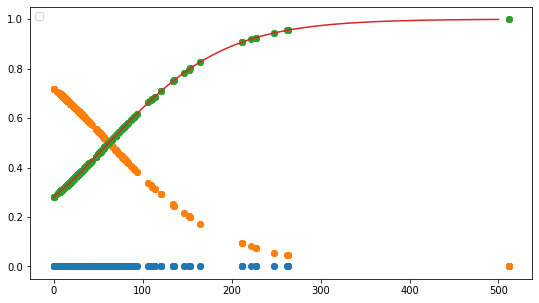

In [26]:
# 各データ（運賃）に対する生死の確率と運賃に対するシグモイド関数の値をプロット

w_0 = model.intercept_[0]
w_1 = model.coef_[0,0]

# def normal_sigmoid(x):
#     return 1 / (1+np.exp(-x))

def sigmoid(x):
    return 1 / (1+np.exp(-(w_1*x+w_0)))

x_range = np.linspace(-1, 500, 3000)

plt.figure(figsize=(9,5))
#plt.xkcd()
plt.legend(loc=2)


# plt.ylim(-0.1, 1.1)
# plt.xlim(-10, 10)

# plt.plot([-10,10],[0,0], "k", lw=1)
# plt.plot([0,0],[-1,1.5], "k", lw=1)
plt.plot(data1,np.zeros(len(data1)), 'o')
plt.plot(data1, model.predict_proba(data1), 'o')
plt.plot(x_range, sigmoid(x_range), '-')
#plt.plot(x_range, normal_sigmoid(x_range), '-')

<h1>1. ロジスティック回帰</h1>
<h3>実装(2変数から生死を判別)</h3>

In [27]:
#AgeFillの欠損値を埋めたので
#titanic_df = titanic_df.drop(['Age'], axis=1)

In [28]:
# 'Sex'の'female': 0, 'male': 1とした、新たな説明変数'Gender'を生成
titanic_df['Gender'] = titanic_df['Sex'].map({'female': 0, 'male': 1}).astype(int)

In [29]:
titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill,Gender
0,0,3,male,22.0,1,0,7.2500,S,22.0,1
1,1,1,female,38.0,1,0,71.2833,C,38.0,0
2,1,3,female,26.0,0,0,7.9250,S,26.0,0


In [30]:
# 'Pclass'と'Gender'を加算した新たな説明変数'Pclass_Gender'を生成（特徴エンジニアリング）
titanic_df['Pclass_Gender'] = titanic_df['Pclass'] + titanic_df['Gender']

In [31]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill,Gender,Pclass_Gender
0,0,3,male,22.0,1,0,7.2500,S,22.0,1,4
1,1,1,female,38.0,1,0,71.2833,C,38.0,0,1
2,1,3,female,26.0,0,0,7.9250,S,26.0,0,3
3,1,1,female,35.0,1,0,53.1000,S,35.0,0,1
4,0,3,male,35.0,0,0,8.0500,S,35.0,1,4


In [32]:
# 説明変数から'Pclass', 'Sex', 'Gender','Age'を削除
titanic_df = titanic_df.drop(['Pclass', 'Sex', 'Gender','Age'], axis=1)

In [33]:
titanic_df.head()

,Survived,SibSp,Parch,Fare,Embarked,AgeFill,Pclass_Gender
0,0,1,0,7.2500,S,22.0,4
1,1,1,0,71.2833,C,38.0,1
2,1,0,0,7.9250,S,26.0,3
3,1,1,0,53.1000,S,35.0,1
4,0,0,0,8.0500,S,35.0,4


In [34]:
# 重要だよ！！！
# 境界線の式
#   w_1・x + w_2・y + w_0 = 0
#   ⇒ y = (-w_1・x - w_0) / w_2
 
# # 境界線 プロット
# plt.plot([-2,2], map(lambda x: (-w_1 * x - w_0)/w_2, [-2,2]))
 
# # データを重ねる
# plt.scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='red', marker='x', label='train 0')
# plt.scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='blue', marker='x', label='train 1')
# plt.scatter(X_test_std[y_test==0, 0], X_test_std[y_test==0, 1], c='red', marker='o', s=60, label='test 0')
# plt.scatter(X_test_std[y_test==1, 0], X_test_std[y_test==1, 1], c='blue', marker='o', s=60, label='test 1')

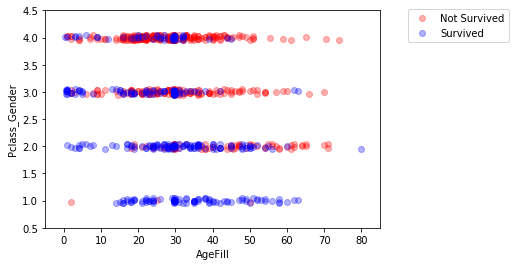

In [35]:
# 'AgeFill'を横軸、'Pclass_Gender'を縦軸にし、全データの生死をプロット
# 　⇒　'AgeFill'が小さく（年齢が若い）、'Pclass_Gender'が小さい（地位が高く女性）ほど生き残る確率が高そう！

np.random.seed = 0

xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5

index_survived = titanic_df[titanic_df["Survived"]==0].index
index_notsurvived = titanic_df[titanic_df["Survived"]==1].index

from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
sc = ax.scatter(titanic_df.loc[index_survived, 'AgeFill'],
                titanic_df.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(titanic_df.loc[index_notsurvived, 'AgeFill'],
                titanic_df.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(bbox_to_anchor=(1.4, 1.03))

In [36]:
#"AgeFill"と"Pclass_Gender"の2変数だけのリストを作成
data2 = titanic_df.loc[:, ["AgeFill", "Pclass_Gender"]].values

In [37]:
data2

array([[22.        ,  4.        ],
       [38.        ,  1.        ],
       [26.        ,  3.        ],
       ...,
       [29.69911765,  3.        ],
       [26.        ,  2.        ],
       [32.        ,  4.        ]])

In [38]:
#生死フラグのみのリストを作成
label2 =  titanic_df.loc[:,["Survived"]].values

In [39]:
# ロジスティック回帰モデルのインスタンスを生成
model2 = LogisticRegression()

In [40]:
# 学習
model2.fit(data2, label2)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# Age=10, Pclass_Gender=1 の生死を予測
model2.predict([[10,1]])    # Age=10, Pclass_Gender=1 ---> survived

array([1], dtype=int64)

In [42]:
# Age=10, Pclass_Gender=1 の生き残る確率を予測
model2.predict_proba([[10,1]])

array([[0.03754749, 0.96245251]])

In [43]:
titanic_df.head(3)

,Survived,SibSp,Parch,Fare,Embarked,AgeFill,Pclass_Gender
0,0,1,0,7.2500,S,22.0,4
1,1,1,0,71.2833,C,38.0,1
2,1,0,0,7.9250,S,26.0,3


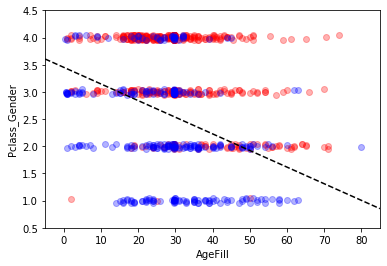

In [44]:
# 'AgeFill'を横軸、'Pclass_Gender'を縦軸にし、全データの生死をプロット
# 　⇒　'AgeFill'が小さく（年齢が若い）、'Pclass_Gender'が小さい（地位が高く女性）ほど生き残る確率が高そう！
# 　⇒　生死の分かれ目の境界のラインを引く

h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = model2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 1.0)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#contour = ax.contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.5)

sc = ax.scatter(titanic_df.loc[index_survived, 'AgeFill'],
                titanic_df.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(titanic_df.loc[index_notsurvived, 'AgeFill'],
                titanic_df.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)

ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
#fig.colorbar(contour)

x1 = xmin
x2 = xmax
# 生死の分かれ目のラインを引く（w1x1+w2x2+w0=0より）
y1 = -1*(model2.intercept_[0]+model2.coef_[0][0]*xmin)/model2.coef_[0][1]
y2 = -1*(model2.intercept_[0]+model2.coef_[0][0]*xmax)/model2.coef_[0][1]
ax.plot([x1, x2] ,[y1, y2], 'k--')

<h1>2. モデル評価</h1>
<h3>混同行列とクロスバリデーション</h3>

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# 'Fare'だけのデータを、訓練データ（80%）とテストデータ（20%）に分割･･･データ１
traindata1, testdata1, trainlabel1, testlabel1 = train_test_split(data1, label1, test_size=0.2)
traindata1.shape
trainlabel1.shape

(712, 1)

In [47]:
# 'AgeFill'と'Pclass_Gender'だけのデータを、訓練データ（80%）とテストデータ（20%）に分割･･･データ２
traindata2, testdata2, trainlabel2, testlabel2 = train_test_split(data2, label2, test_size=0.2)
traindata2.shape
trainlabel2.shape
#本来は同じデータセットを分割しなければいけない。(簡易的に別々に分割している。)

(712, 1)

In [48]:
# 元の全ての説明変数のデータを、訓練データ（80%）とテストデータ（20%）に分割
data = titanic_df.loc[:, ].values
label =  titanic_df.loc[:,["Survived"]].values
traindata, testdata, trainlabel, testlabel = train_test_split(data, label, test_size=0.2)
traindata.shape
trainlabel.shape

(712, 1)

In [49]:
# ロジスティック回帰モデルの各インスタンスを生成
eval_model1=LogisticRegression()
eval_model2=LogisticRegression()
#eval_model=LogisticRegression()

In [50]:
# 各モデルでそれぞれ学習
predictor_eval1=eval_model1.fit(traindata1, trainlabel1).predict(testdata1)
predictor_eval2=eval_model2.fit(traindata2, trainlabel2).predict(testdata2)
#predictor_eval=eval_model.fit(traindata, trainlabel).predict(testdata)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
# データ１（Fareのみ）に対するモデルを評価　⇒　訓練データの正解率＝0.671
eval_model1.score(traindata1, trainlabel1)

0.6657303370786517

In [52]:
# データ１（Fareのみ）に対するモデルを評価　⇒　テストデータの正解率＝0.648
eval_model1.score(testdata1,testlabel1)

0.659217877094972

In [53]:
# データ２（'AgeFill'と'Pclass_Gender'）に対するモデルを評価　⇒　訓練データの正解率＝0.774
eval_model2.score(traindata2, trainlabel2)

0.7682584269662921

In [54]:
# データ２（'AgeFill'と'Pclass_Gender'）に対するモデルを評価　⇒　テストデータの正解率＝0.760
eval_model2.score(testdata2,testlabel2)

0.770949720670391

In [55]:
# sklearnのmetricsにより、各データのテストデータに対する識別レポートを出力
from sklearn import metrics
print(metrics.classification_report(testlabel1, predictor_eval1))
print(metrics.classification_report(testlabel2, predictor_eval2))

              precision    recall  f1-score   support

           0       0.65      0.93      0.77       108
           1       0.69      0.25      0.37        71

    accuracy                           0.66       179
   macro avg       0.67      0.59      0.57       179
weighted avg       0.67      0.66      0.61       179

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       103
           1       0.77      0.66      0.71        76

    accuracy                           0.77       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



In [56]:
# sklearnのmetricsにより、各データのテストデータに対する混同行列を計算
# seabornのheatmapにより混同行列をプロット

from sklearn.metrics import confusion_matrix
confusion_matrix1=confusion_matrix(testlabel1, predictor_eval1)
confusion_matrix2=confusion_matrix(testlabel2, predictor_eval2)

In [57]:
confusion_matrix1

array([[100,   8],
       [ 53,  18]], dtype=int64)

In [58]:
confusion_matrix2

array([[88, 15],
       [26, 50]], dtype=int64)

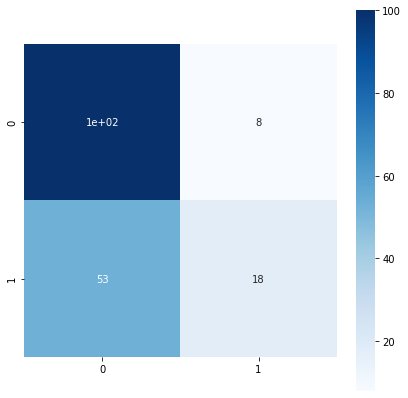

In [59]:
fig = plt.figure(figsize = (7,7))
#plt.title(title)
sns.heatmap(
    confusion_matrix1,
    vmin=None,
    vmax=None,
    cmap="Blues",
    center=None,
    robust=False,
    annot=True, fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=True, ax=None, 
    #xticklabels=columns,
    #yticklabels=columns,
    mask=None)

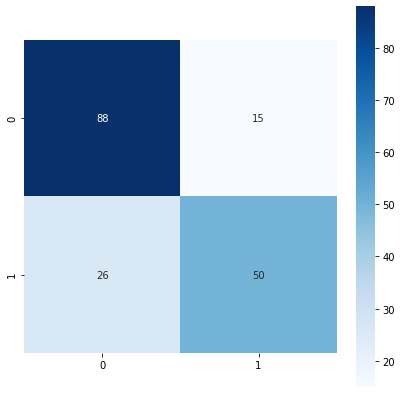

In [60]:
fig = plt.figure(figsize = (7,7))
#plt.title(title)
sns.heatmap(
    confusion_matrix2,
    vmin=None,
    vmax=None,
    cmap="Blues",
    center=None,
    robust=False,
    annot=True, fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=True, ax=None, 
    #xticklabels=columns,
    #yticklabels=columns,
    mask=None)

C:\Users\user\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


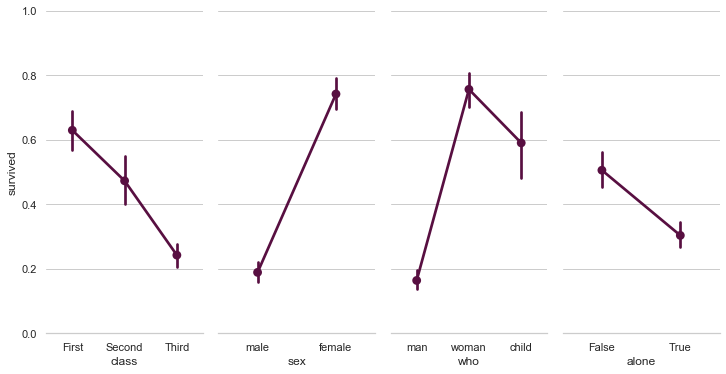

In [61]:
#Paired categorical plots
# seabornのPairGridにより、データセットのペア毎（"survived"と"class", "sex", "who", "alone"のペア）
# の関係を表示

import seaborn as sns
sns.set(style="whitegrid")

# Load the example Titanic dataset
titanic = sns.load_dataset("titanic")

# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(titanic, y_vars="survived",
                 x_vars=["class", "sex", "who", "alone"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

plt.show()

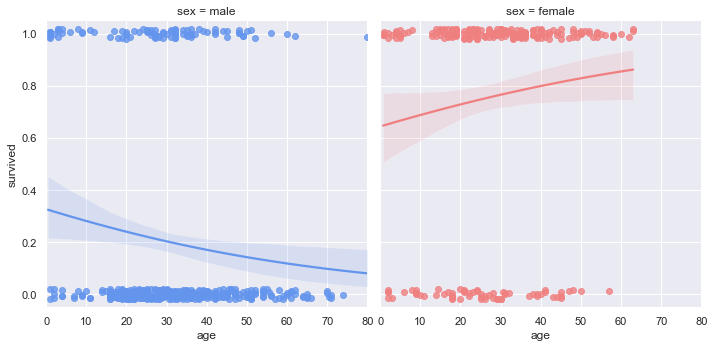

In [62]:
# Faceted logistic regression
# seabornのimplotにより、2次元のデータ（AgeとSex）と線形回帰モデルの結果を重ねてプロット、
#　複数のグラフをまとめて1度に出力

import seaborn as sns
sns.set(style="darkgrid")

# Load the example titanic dataset
df = sns.load_dataset("titanic")

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
               palette=pal, y_jitter=.02, logistic=True)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))
plt.show()

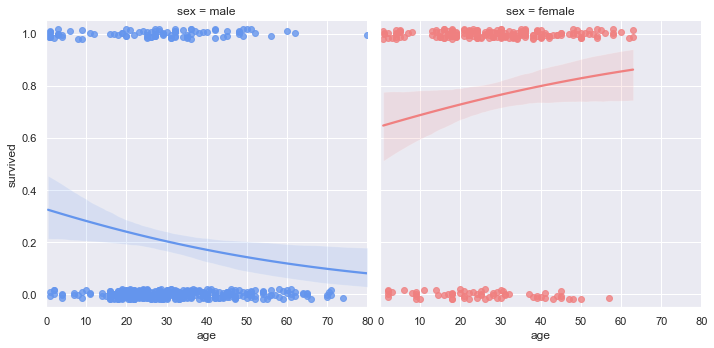

In [63]:
# Faceted logistic regression
# seabornのimplotにより、2次元のデータ（AgeとSex）と線形回帰モデルの結果を重ねてプロット、
#　複数のグラフをまとめて1度に出力

import seaborn as sns
sns.set(style="darkgrid")

# Load the example titanic dataset
df = sns.load_dataset("titanic")

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
               palette=pal, y_jitter=.02, logistic=True)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))
plt.show()